In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
from jax import random, vmap
from jaxtyping import Array, Float32, UInt32

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
def generate_intermediate_counts(
    rng_key: UInt32[Array, "2"],
    n_series: int,
    t_max_train: int,
    t_max_test: int,
    a: float = 1.0,
) -> tuple[
    Float32[Array, "t_max_train n_series"], Float32[Array, "t_max_test n_series"]
]:
    rng_key, rng_subkey = random.split(rng_key)
    lambdas = random.gamma(rng_subkey, a=a, shape=(1, n_series))

    t_max = t_max_train + t_max_test
    rng_key, rng_subkey = random.split(rng_key)
    counts = random.poisson(rng_subkey, lam=lambdas, shape=(t_max, n_series))
    counts = counts.astype(jnp.float32)

    return counts[:t_max_train, :], counts[t_max_train:, :]

In [3]:
counts_train, counts_test = generate_intermediate_counts(
    rng_key, n_series=500, t_max_train=30, t_max_test=10, a=1.0
)

print(f"counts_train.shape: {counts_train.shape}")
print(f"counts_test.shape: {counts_test.shape}")

counts_train.shape: (30, 500)
counts_test.shape: (10, 500)


In [4]:
t_train = jnp.arange(counts_train.shape[0])
t_test = jnp.arange(counts_train.shape[0], counts_train.shape[0] + counts_test.shape[0])

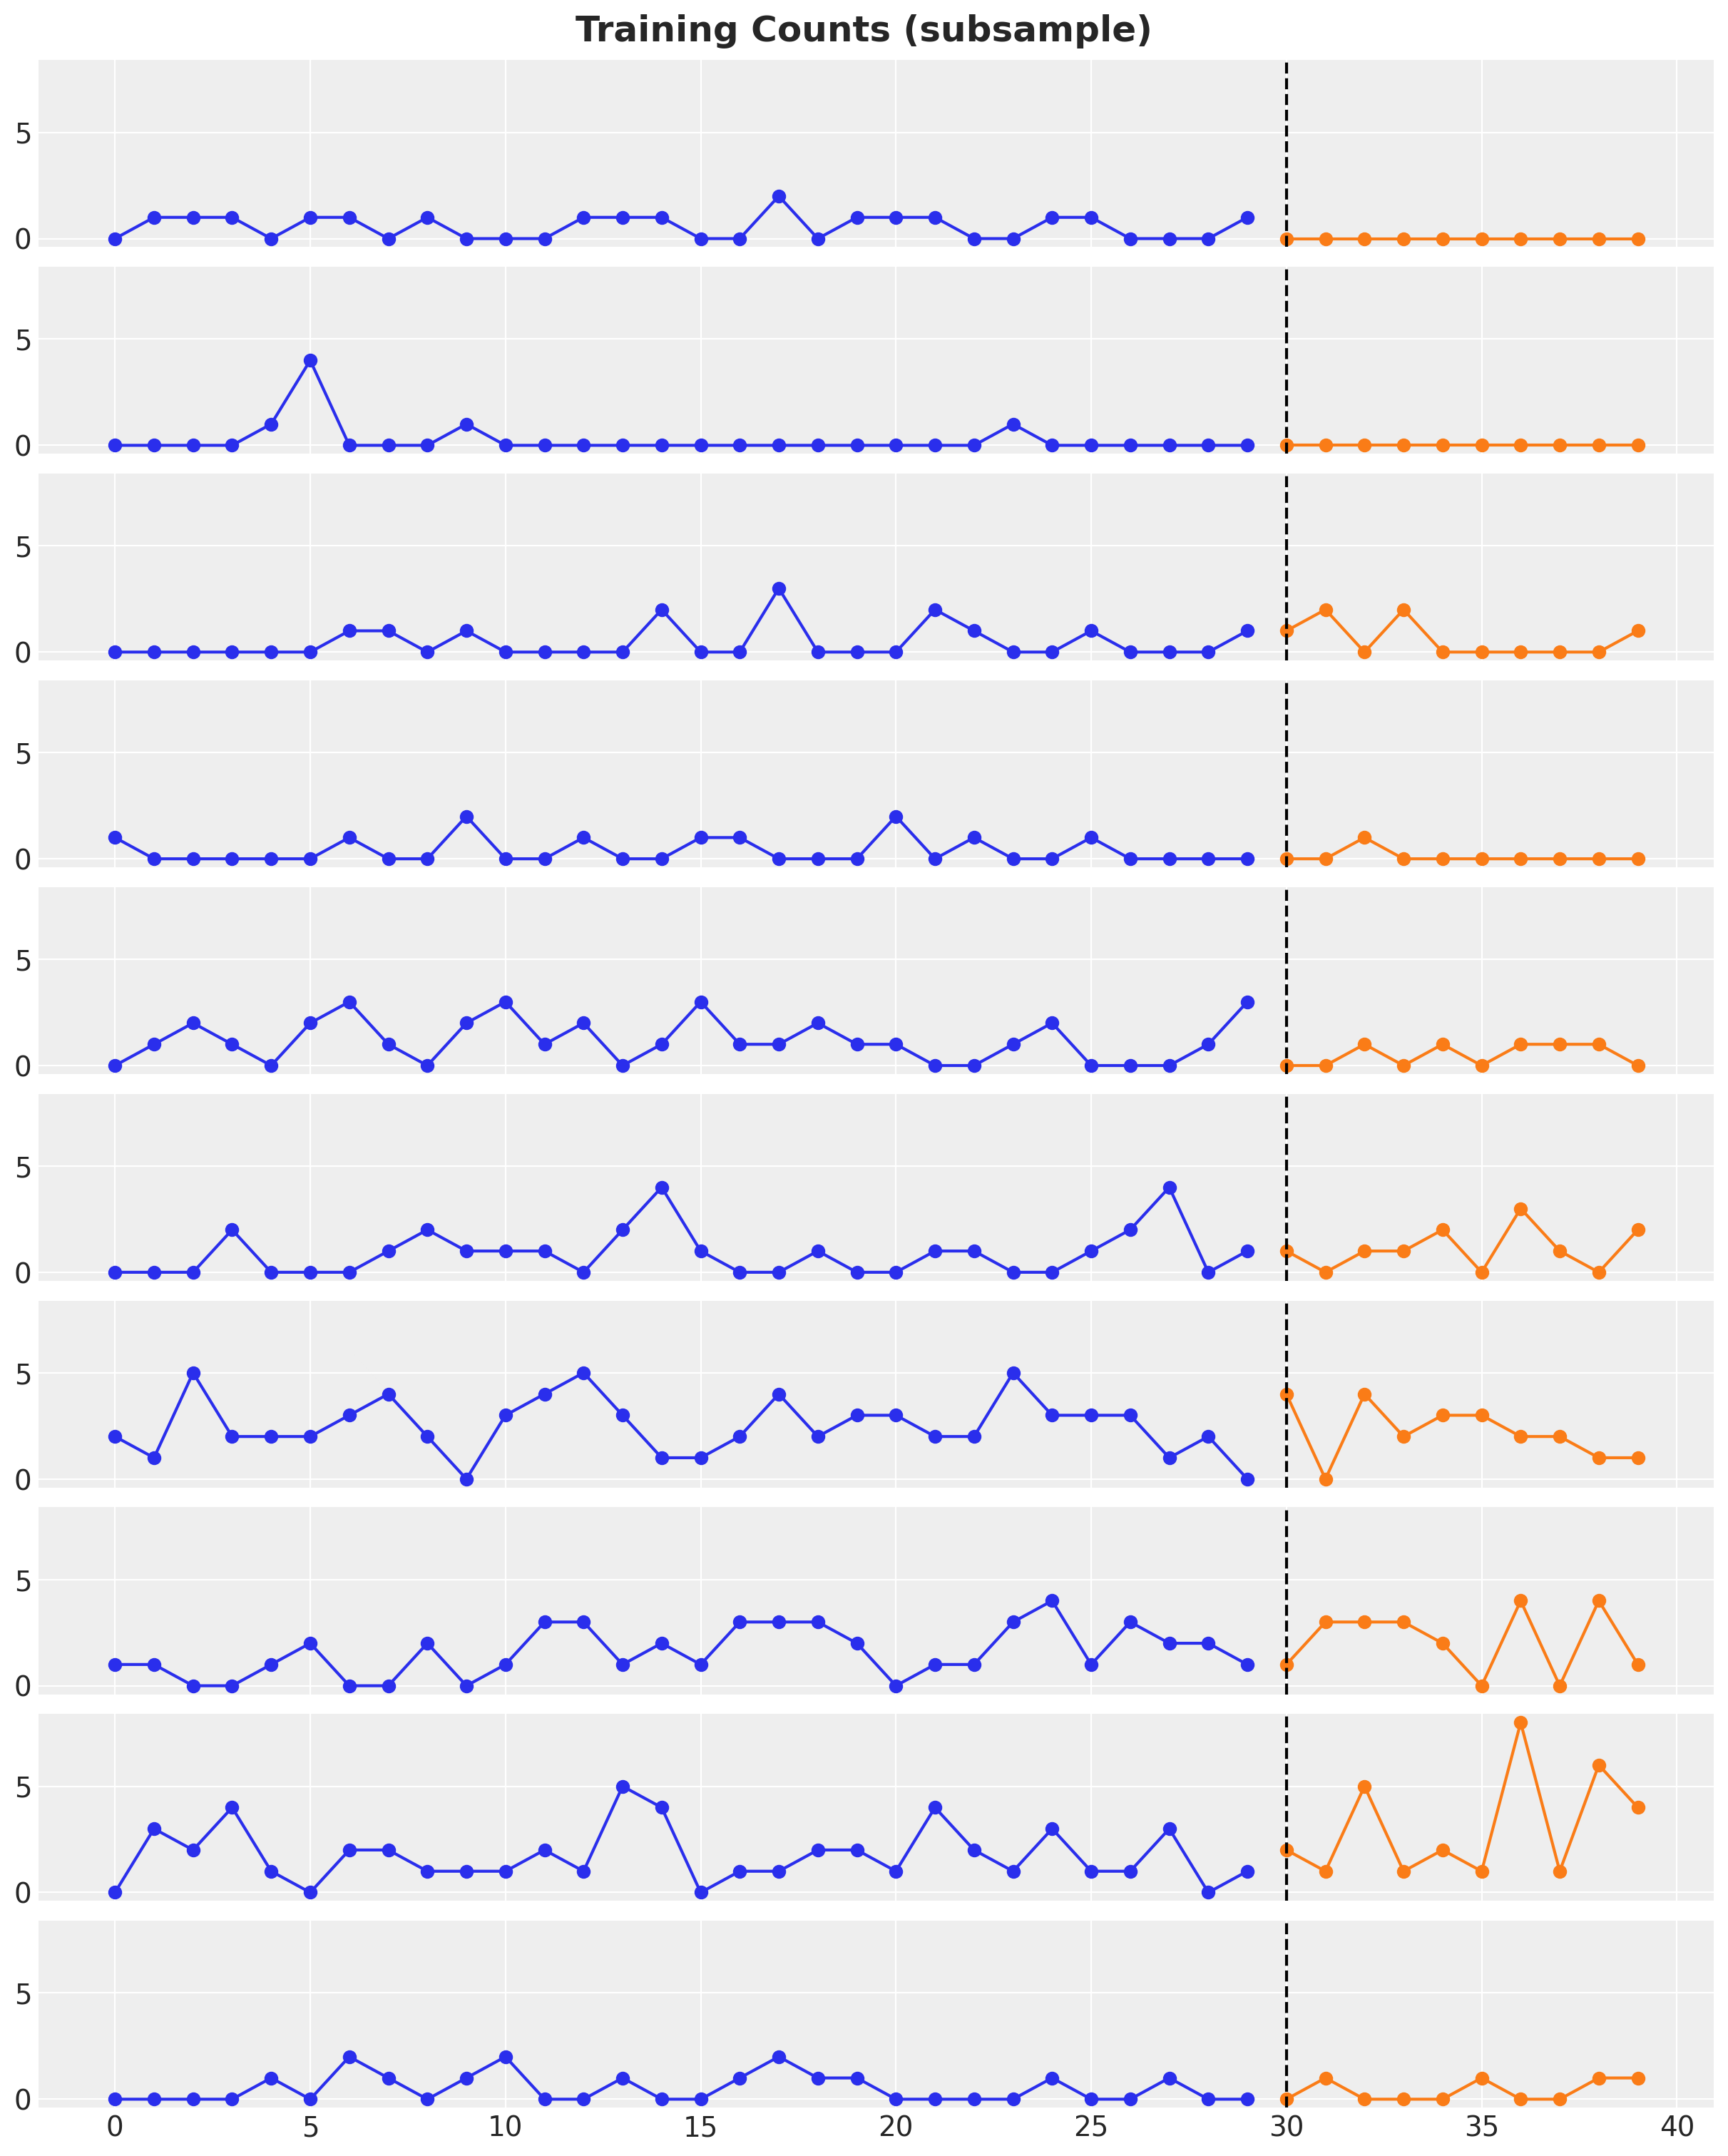

In [5]:
n_series_to_plot = 10

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    ax[i].plot(t_train, counts_train[:, i], marker="o", color="C0")
    ax[i].plot(t_test, counts_test[:, i], marker="o", color="C1")
    ax[i].axvline(x=t_train.shape[0], color="k", linestyle="--")

fig.suptitle("Training Counts (subsample)", fontsize=18, fontweight="bold");

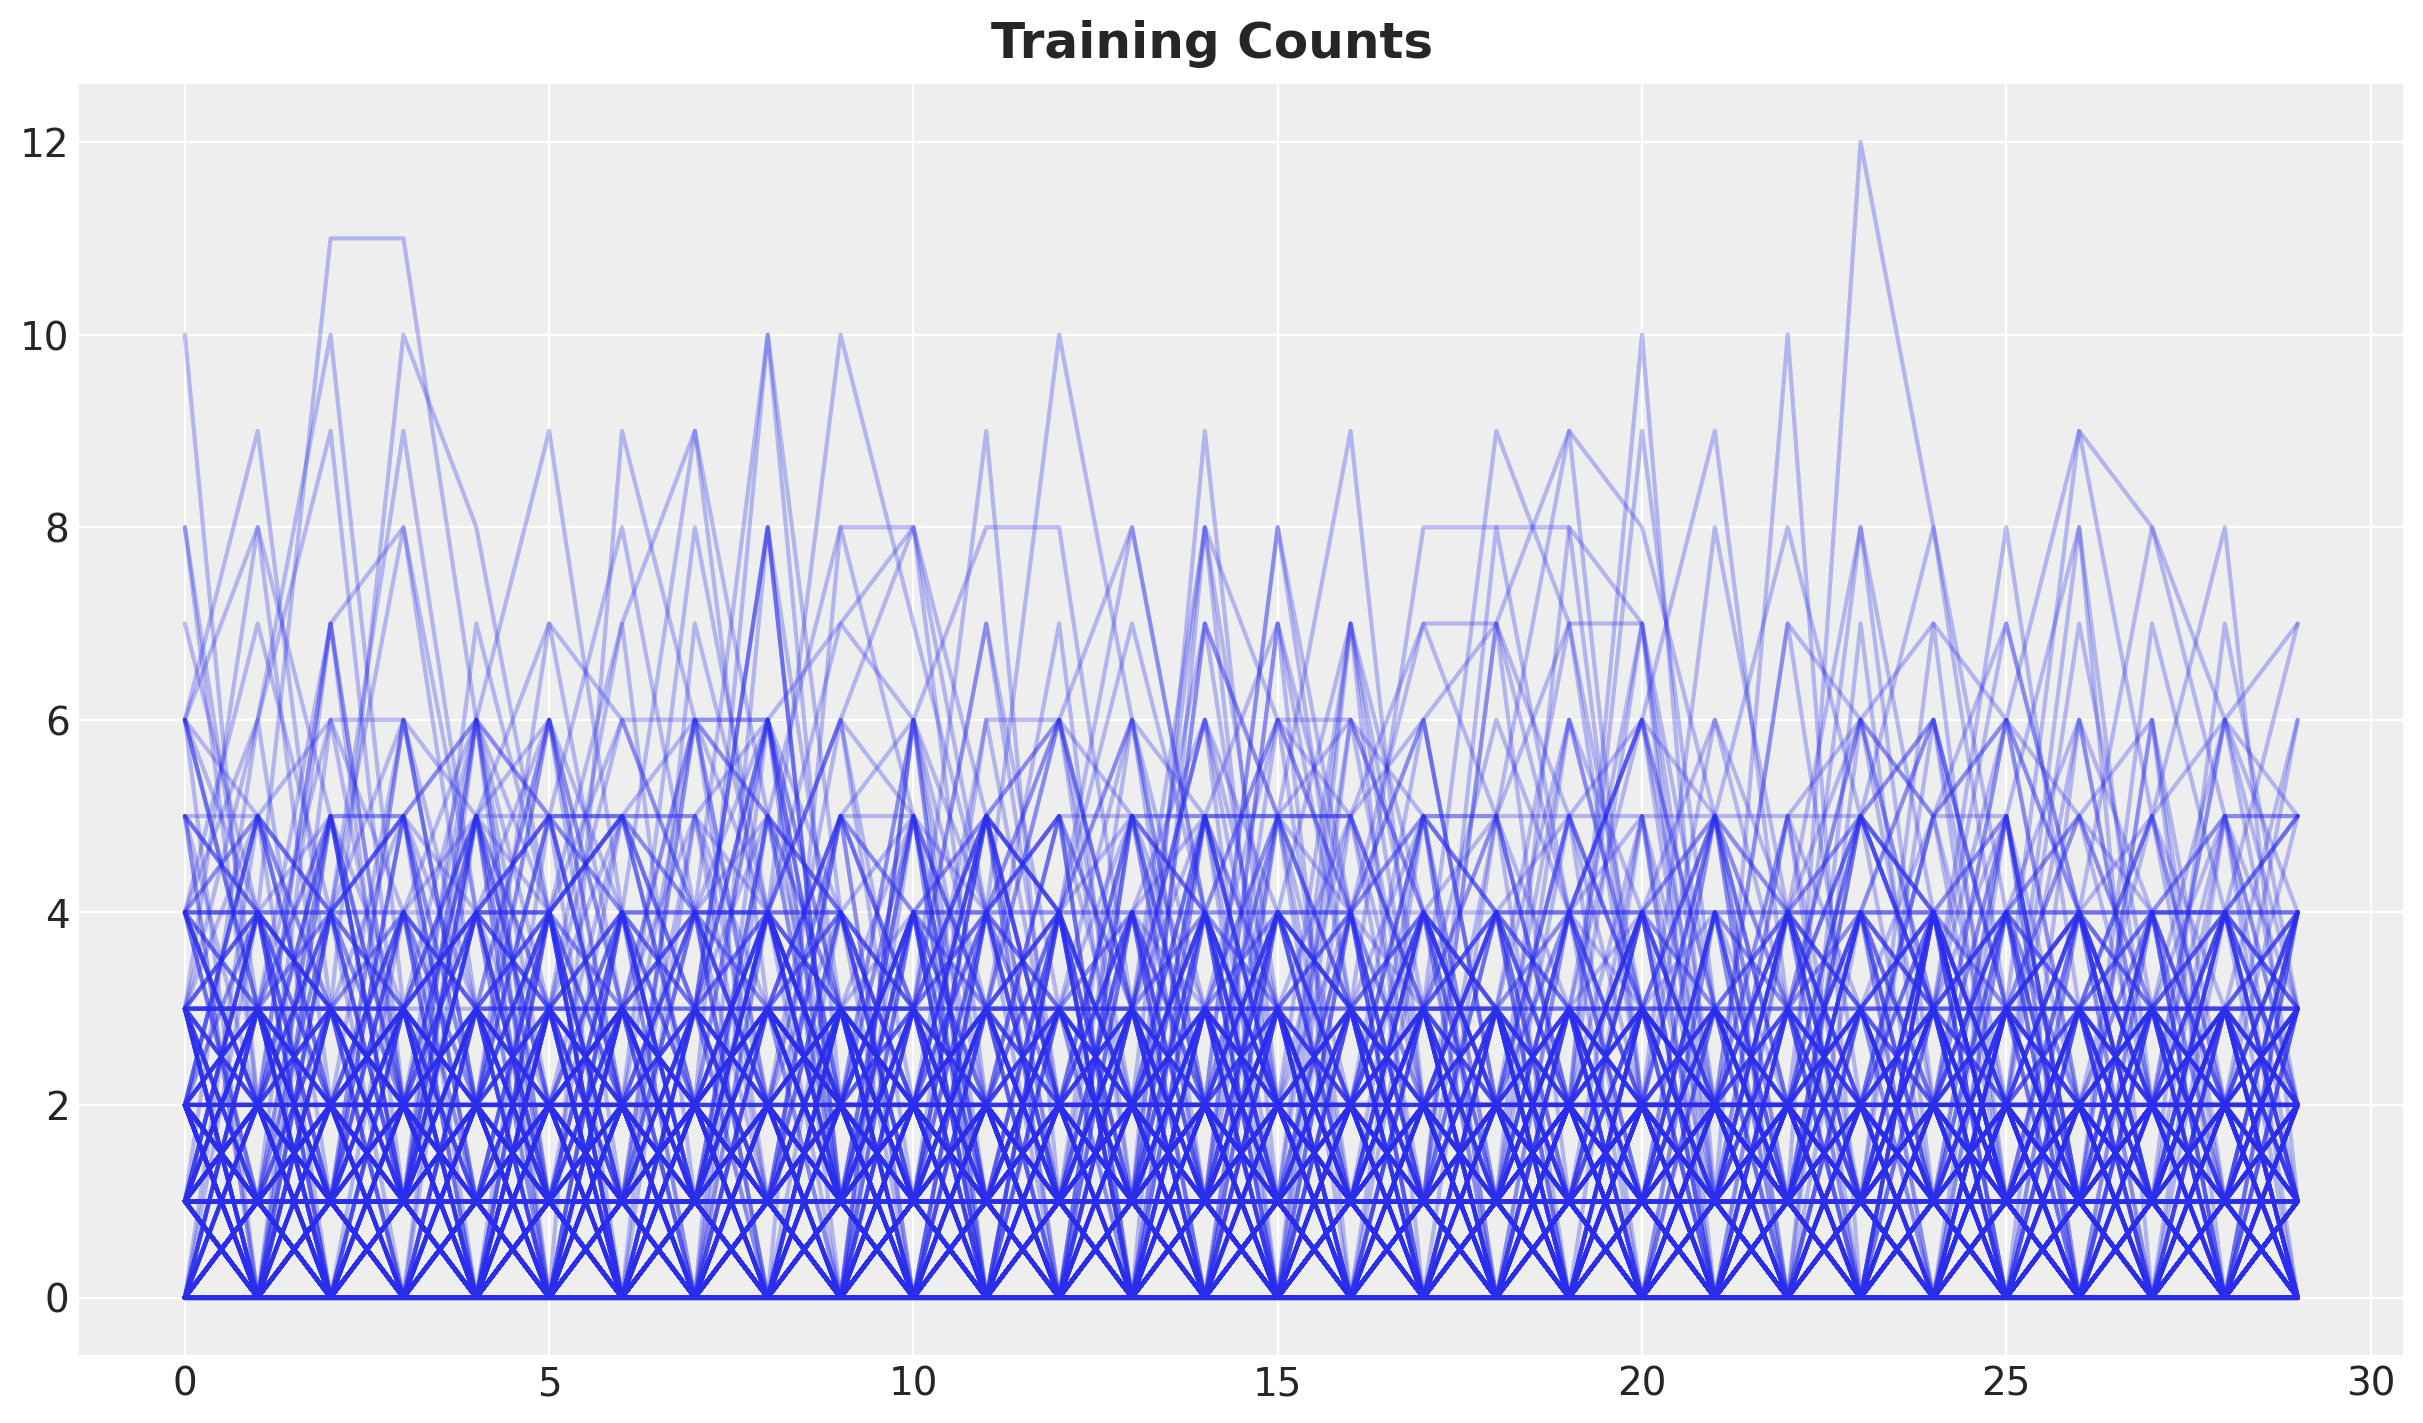

In [6]:
fig, ax = plt.subplots()
ax.plot(t_train, counts_train, c="C0", alpha=0.3)
fig.suptitle("Training Counts", fontsize=18, fontweight="bold");

In [61]:
def replace_leading_zeros_with_nans(x: Float32[Array, " t"]) -> Float32[Array, " t"]:
    # Find first non-zero element
    first_nonzero = jnp.argmax(x != 0)

    # Create mask that is True for leading zeros
    leading_zeros_mask = jnp.arange(x.shape[0]) < first_nonzero

    # Replace leading zeros with NaNs
    return jnp.where(leading_zeros_mask, jnp.nan, x)


x = jnp.array([0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 0.0, 0.0, 0.0])

replace_leading_zeros_with_nans(x)

Array([nan, nan, nan,  1.,  2.,  3.,  0.,  0.,  0.], dtype=float32)

In [60]:
counts_train_masked = vmap(replace_leading_zeros_with_nans, in_axes=(1,), out_axes=1)(
    counts_train
)

assert counts_train_masked.shape == counts_train.shape

assert jnp.allclose(
    jnp.where(jnp.isnan(counts_train_masked), 0.0, counts_train_masked), counts_train
)

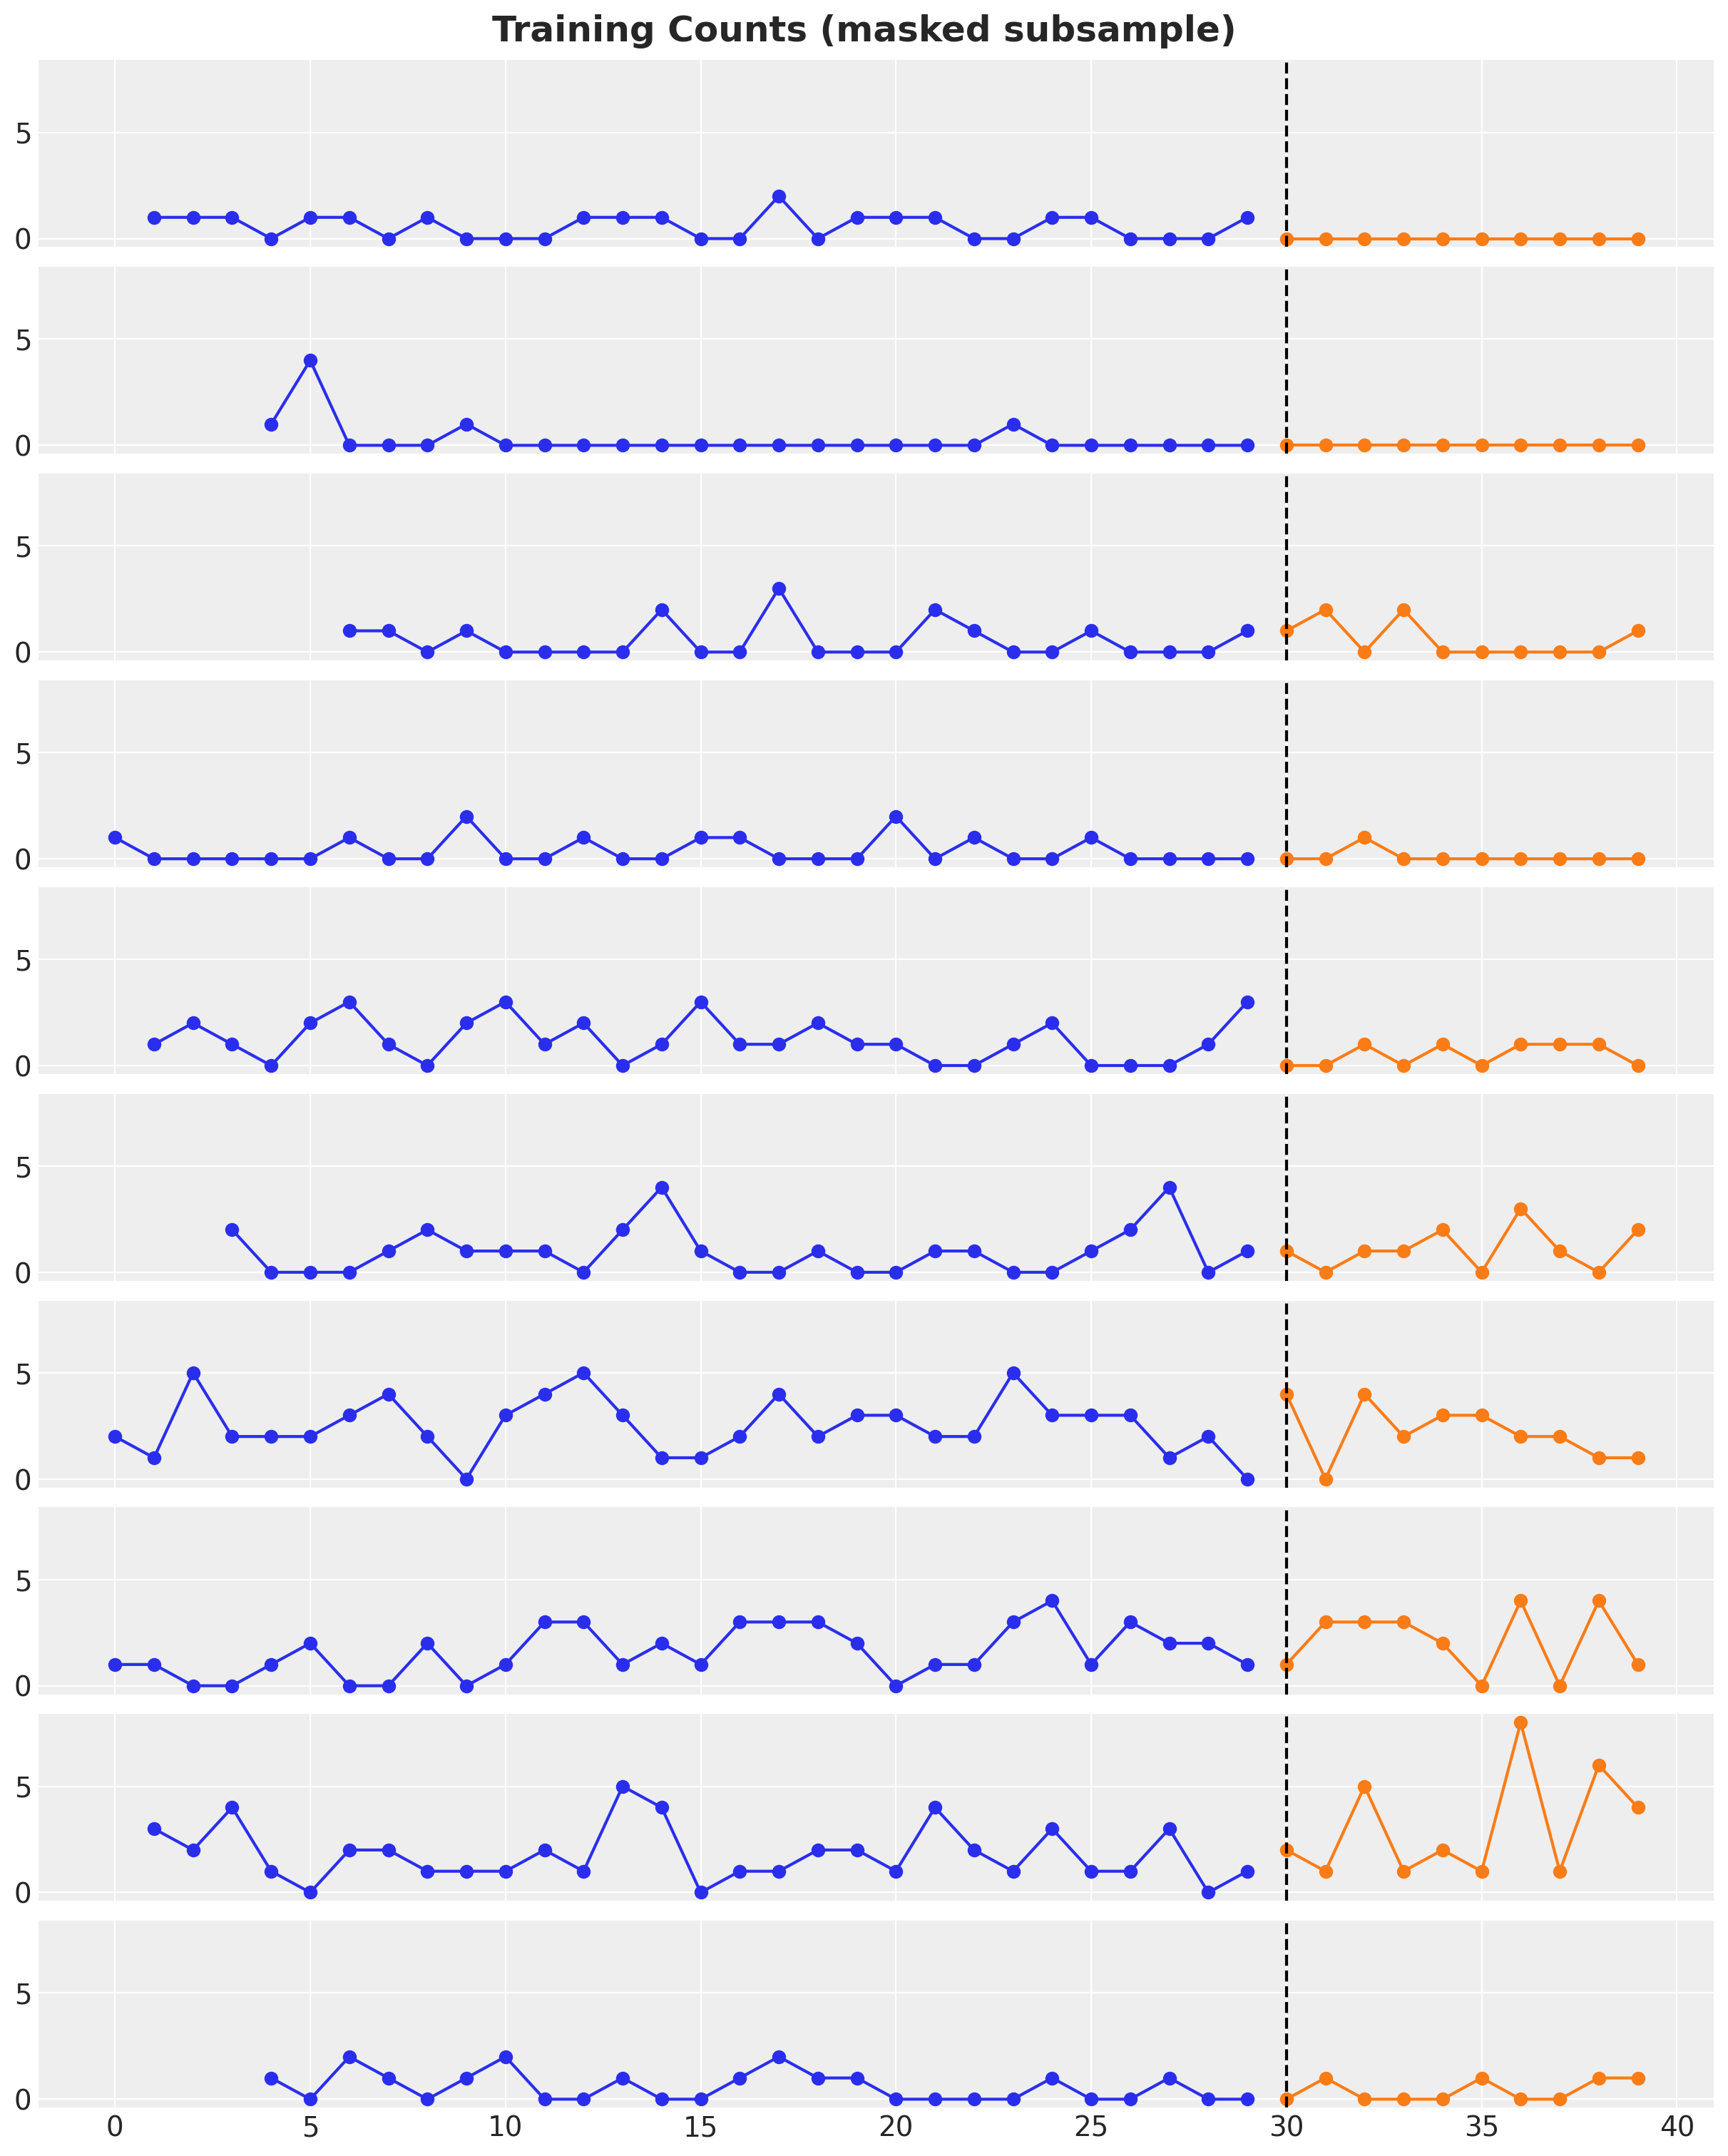

In [62]:
n_series_to_plot = 10

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    ax[i].plot(t_train, counts_train_masked[:, i], marker="o", color="C0")
    ax[i].plot(t_test, counts_test[:, i], marker="o", color="C1")
    ax[i].axvline(x=t_train.shape[0], color="k", linestyle="--")

fig.suptitle("Training Counts (masked subsample)", fontsize=18, fontweight="bold");